In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.patheffects as fx

params = {
#                       "figure.figsize" :  [7, 5],  # figure size in inches
#                       "figure.dpi"     :  300,       # figure dots per inch
#                       "font.size"      :  8,         #  tick labels
#                       "font.family"    : "Times New Roman",
                       'svg.fonttype'    : 'none',  # plot text as text - not paths or clones or other nonsense
                       "ytick.labelsize": 10, # for colorbar ticks
                       "axes.labelsize" : 10, # for colorbar labels
}

plt.rcParams.update(params)


In [2]:
import eurec4a
cat = eurec4a.get_intake_catalog()
botany_cat = cat.simulations.DALES.botany

ds_timeseries = botany_cat.dx100m.nx1536['timeseries'].to_dask()
ds_profiles = botany_cat.dx100m.nx1536['profiles'].to_dask()
ds_cross = botany_cat.dx100m.nx1536['cross_xy'].to_dask()
ds_2D = botany_cat.dx100m.nx1536['2D'].to_dask()
ds_3D = botany_cat.dx100m.nx1536['3D'].to_dask()


In [3]:
botany_cat.dx100m.nx1536

nx1536:
  args:
    path: https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/Simulations/DALES/botany_dx100m_nx1536.yaml
  description: 'Cloud botany: DALES LES ensemble with varied forcings at 100m grid
    spacing'
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/Simulations/DALES


In [4]:
ds_timeseries

<xarray.Dataset>
Dimensions:  (member: 103, time: 3600)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
  * time     (time) datetime64[ns] 2020-02-01T00:01:00 ... 2020-02-03T12:00:00
Data variables: (12/22)
    cfrac    (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    lmax     (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    lwp_bar  (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    lwp_max  (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    obukh    (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    qtstr    (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    ...       ...
    wthetav  (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    z0       (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    zb       (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    zc_av    (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    zc_max   (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
    zi       (member, time) float32 dask.array<chunksize=(103, 3600), meta=np.ndarray>
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.345
    title:    tmser.001.nc

In [5]:
# functions for plotting cloud albedo and rain water path
start_time = np.datetime64('2020-02-01')
color1 ='#0080ff00' # transparent cyan
color2 ='#0080ffff' # solid cyan
cmap_rain = matplotlib.colors.LinearSegmentedColormap.from_list('my_cmap2',[color1,color2],256)
rwpmax = 3

def albedo(lwp, Nc=70000000):
    # Albedo using model from Zhang et al. (2005), doi:10.1256/qj.04.103
    tau = 0.19 * lwp**(5./6) * Nc**(1.0/3)
    alb = tau/(6.8 + tau)
    return alb

# inverse funcion, mapping albedo to LWP
def albedo_inv(alb, Nc=70000000):
    epsilon=1e-6
    tau = 6.8*alb/(1-alb+epsilon)   # epsilon: avoid problem at alb=1
    lwp = (tau/(0.19*Nc**(1.0/3)))**(6.0/5)
    return lwp

dpi = 80
size = 768

# A single field in one plot
def cloudplot(time, member=1, roll=(0,0)):
    # roll (x,y) can be used to shift the image over the periodic boundary conditions
    
    plt.figure(figsize=(size/dpi, size/dpi), dpi=dpi)
    plt.gca().set_position([0, 0, 1, 1]) # fill whole image
    
    time_ns = start_time + np.timedelta64(time, 'h')
    lwp = ds_2D.lwp.sel(member=member,time=time_ns,method='nearest')
    rwp = ds_2D.rwp.sel(member=member,time=time_ns,method='nearest')
        
    lwp = np.roll(lwp, roll, (0,1))
    rwp = np.roll(rwp, roll, (0,1))
    
    fig_lwp = plt.imshow(albedo(lwp),   cmap='Greys_r', vmin=0, vmax=1)
    fig_rwp = plt.imshow(rwp, cmap=cmap_rain, vmin=0, vmax=rwpmax)
    plt.axis('off')
    
    #label the plot
    str = f"Run {member} at {time} h"
    text=plt.text(0.65, 0.04, str, size=25, weight='bold', transform=plt.gcf().transFigure)
    text.set_path_effects([fx.Stroke(linewidth=3,foreground='1.0'), fx.Normal()])
    plt.savefig(f'albedo-{member}-{time}.png')
    return fig_lwp, fig_rwp

# Create plot in provided axes, for use with subplots
def cloudplot_ax(ax, time, member=1, roll=(0,0), label=''):
    # roll (x,y) can be used to shift the image over the periodic boundary conditions
        
    time_ns = start_time + np.timedelta64(time, 'h')
    lwp = ds_2D.lwp.sel(member=member,time=time_ns,method='nearest')
    rwp = ds_2D.rwp.sel(member=member,time=time_ns,method='nearest')
    #lwp = np.zeros((1536,1536))
    #rwp = np.zeros((1536,1536))
    
    lwp = np.roll(lwp, roll, (0,1))
    rwp = np.roll(rwp, roll, (0,1))
    
    fig_lwp = ax.imshow(albedo(lwp),   cmap='Greys_r', vmin=0, vmax=1)
    fig_rwp = ax.imshow(rwp, cmap=cmap_rain, vmin=0, vmax=rwpmax)
    plt.axis('off')
    
    #label the plot
    str = f"Run {member} at {time} h"
    text=plt.text(0.50, 0.04, str, size=8, weight='bold', transform=ax.transAxes)
    text.set_path_effects([fx.Stroke(linewidth=1.3,foreground='1.0'), fx.Normal()])    
    
    lab=plt.text(0.03, 0.93, label, size=8, weight='bold', transform=ax.transAxes)
    lab.set_path_effects([fx.Stroke(linewidth=1.3,foreground='1.0'), fx.Normal()])    
    return fig_lwp, fig_rwp


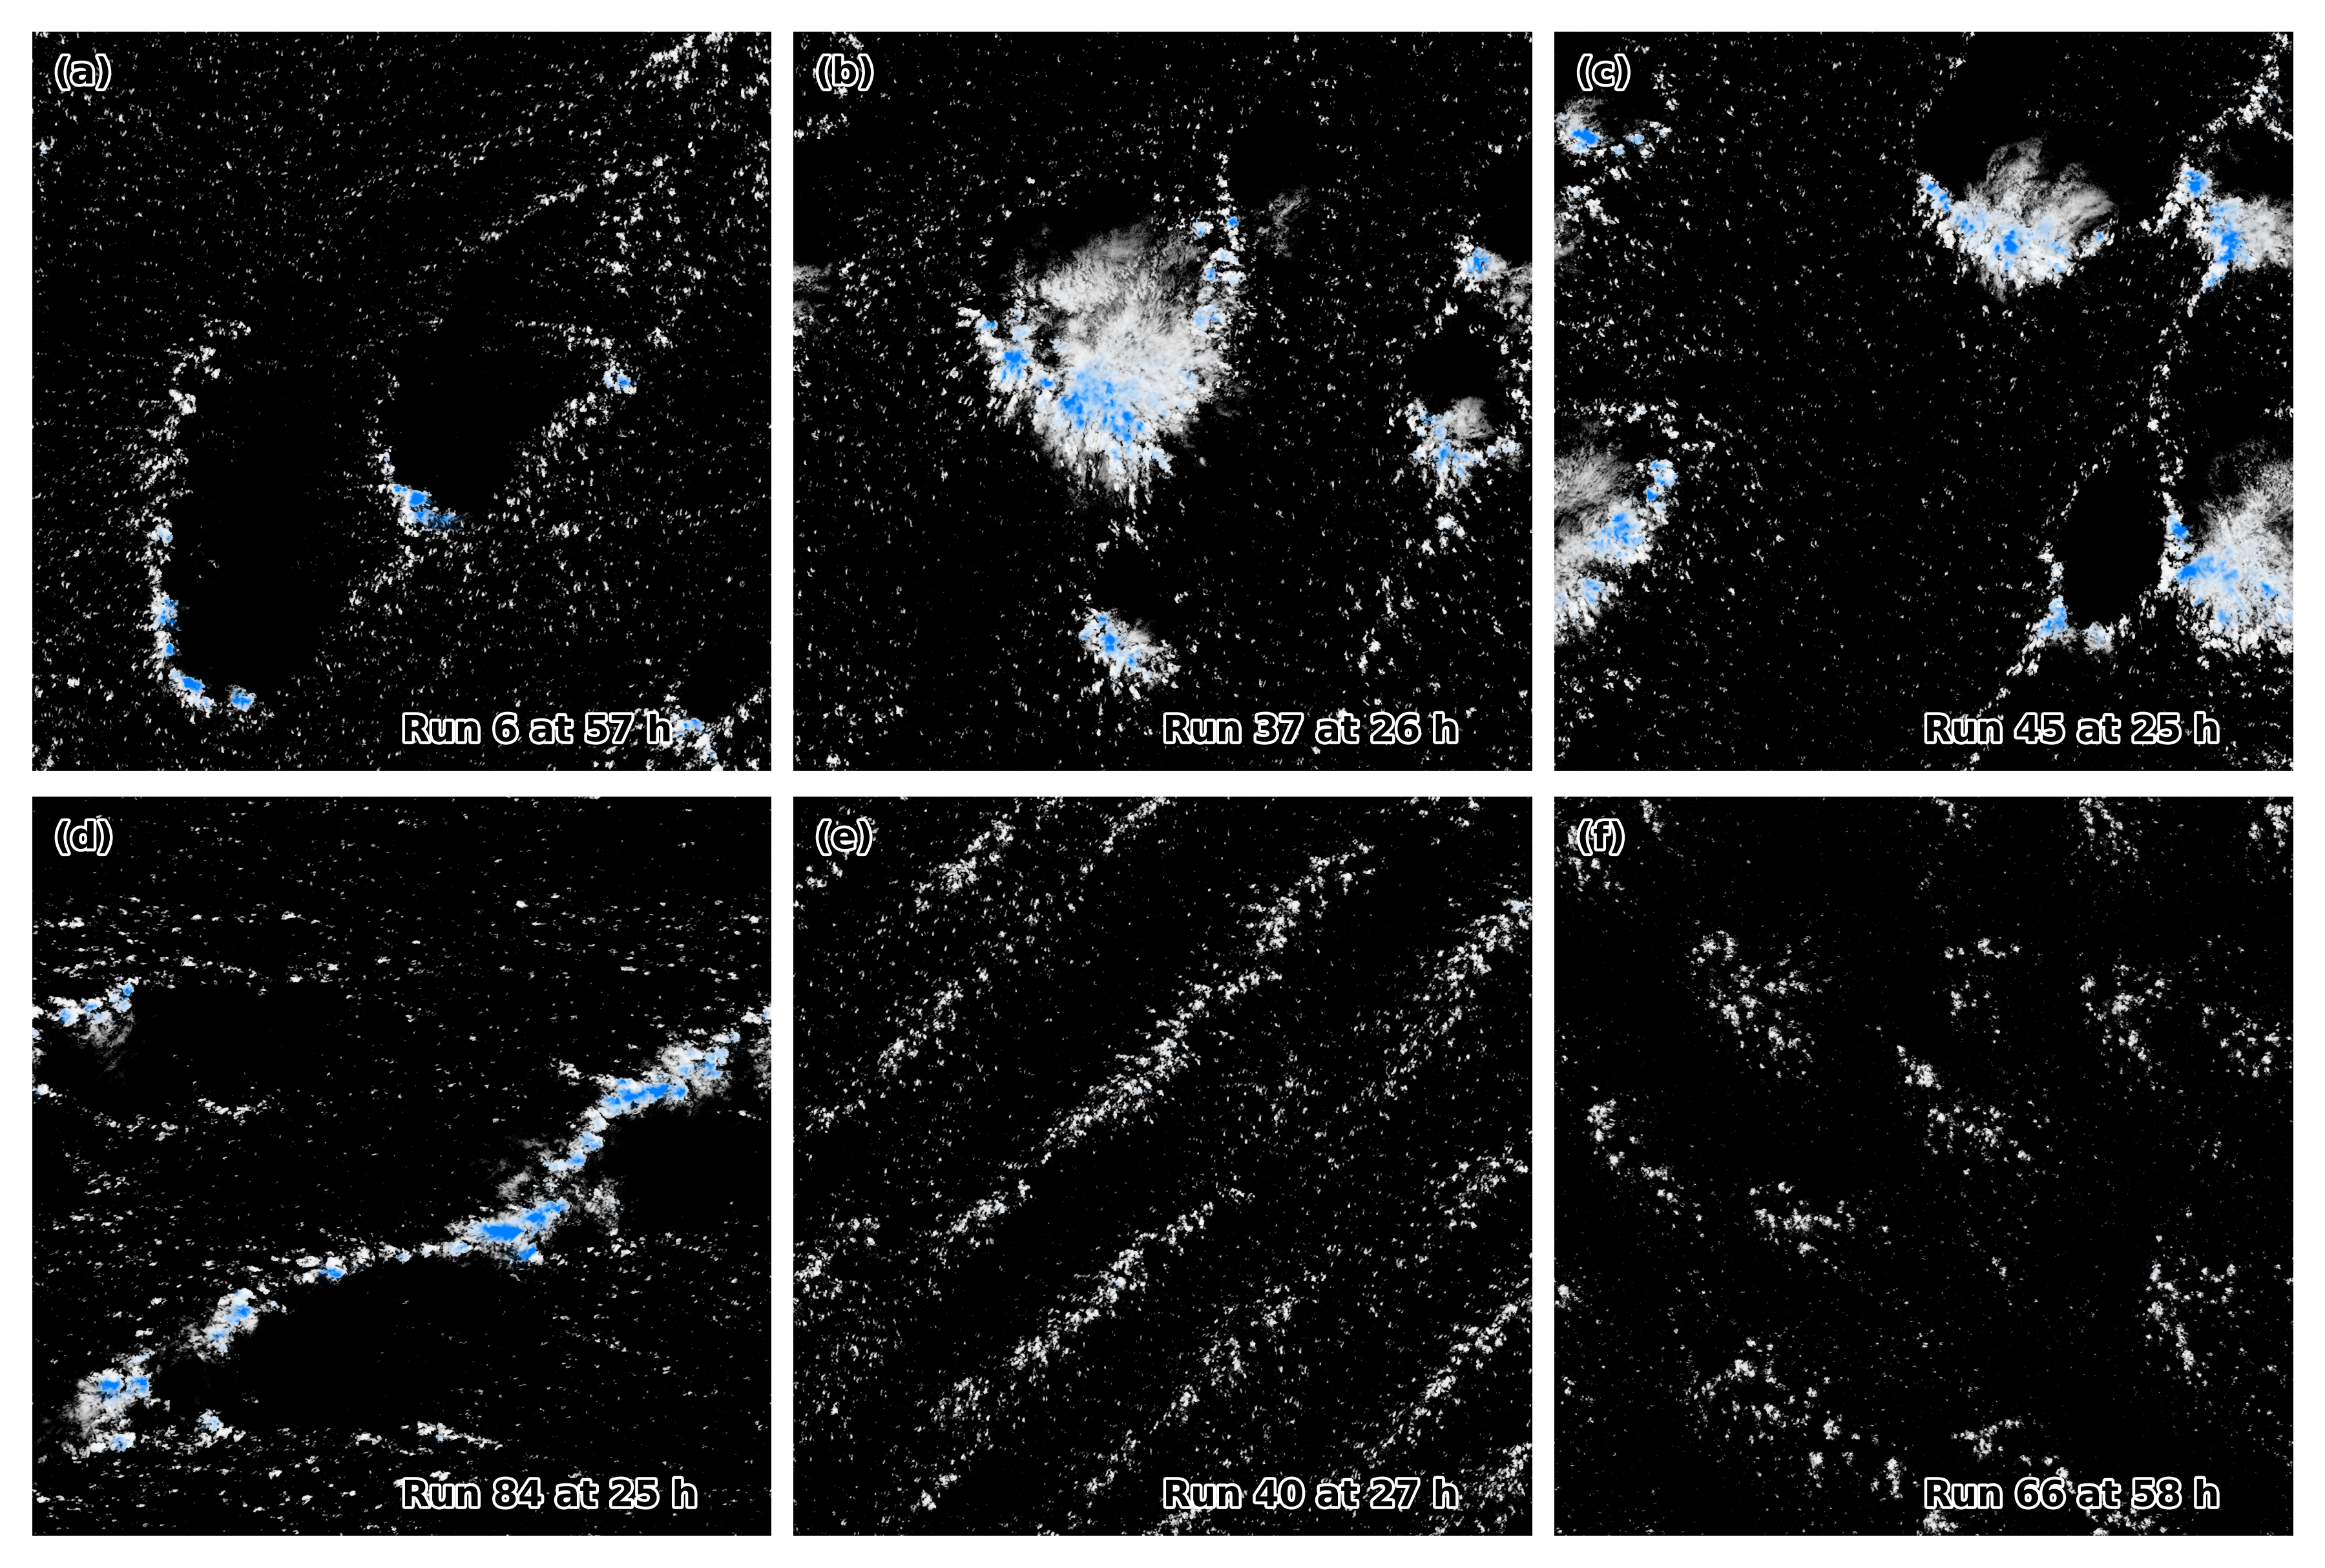

In [6]:
# Figure 5
fig, axes = plt.subplots(2, 3, figsize=(7, 7*2/3), dpi=500)
for a in axes.flatten():
    a.axis('off')
    #a.set_position([0, 0, 1, 1])

plt.subplots_adjust(wspace=.03, hspace=.03, left=0, right=1, top=1, bottom=0)
    
    
# Figure 5a, cold pools
cloudplot_ax(axes[0,0], 57, member=6, roll=(-400,-800), label='(a)')

#Figure 5b, cold pool with stratiform outflow, flower-like
cloudplot_ax(axes[0,1], 26, member=37, roll=(-600,300), label='(b)')

#Figure 5c, striped cumulus, before precip
cloudplot_ax(axes[0,2], 25, member=45, label='(c)')

#Figure 5d, line
cloudplot_ax(axes[1,0], 25, member=84, roll=(-800,-100), label='(d)')

#Figure 5e, striped cumulus, before precip
cloudplot_ax(axes[1,1], 27, member=40, label='(e)')

# Figure 5f, clusters
cloudplot_ax(axes[1,2], 58, member=66, roll=(-400,-800), label='(f)')

plt.savefig('snapshots.pdf')
plt.show()

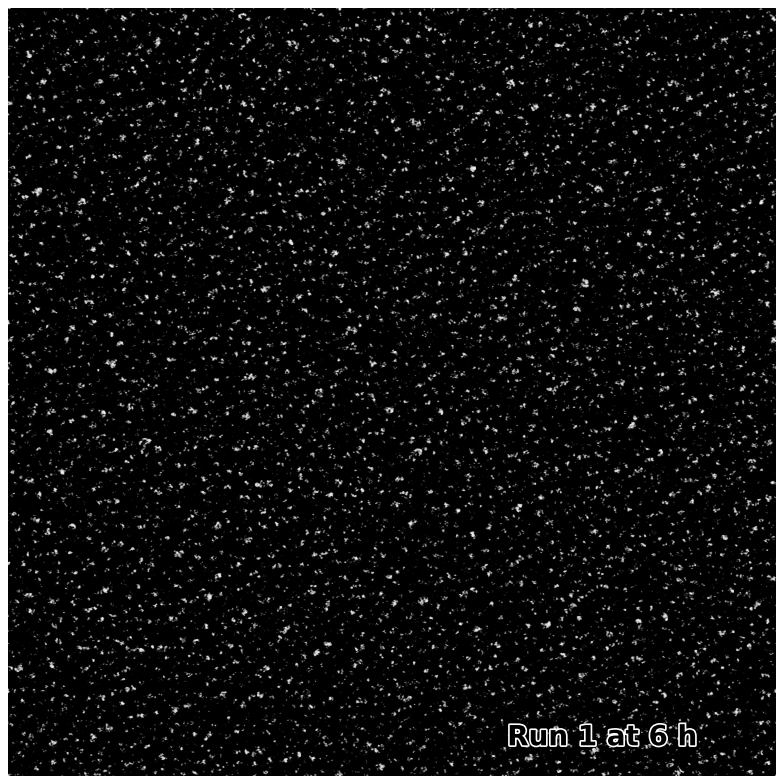

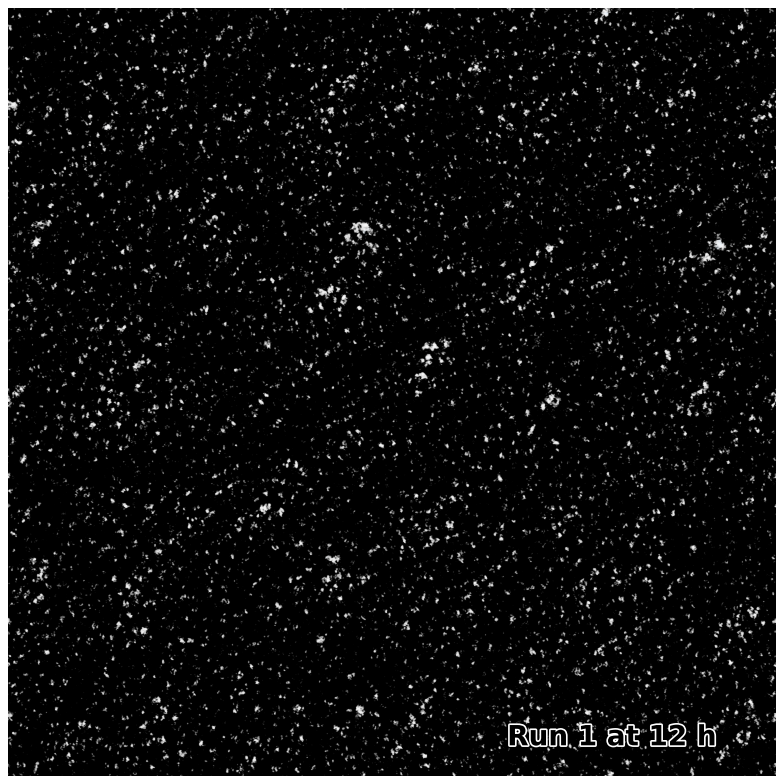

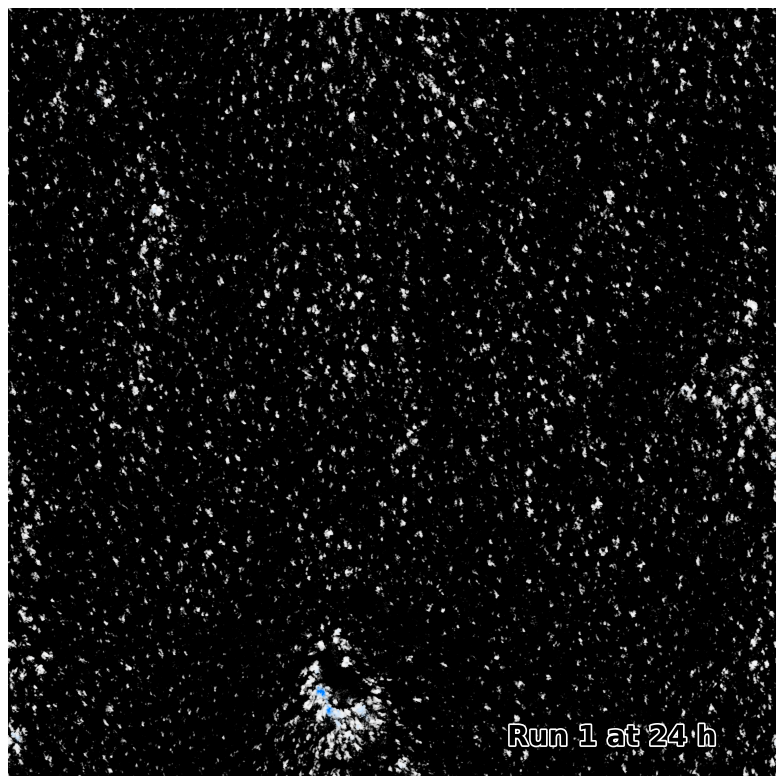

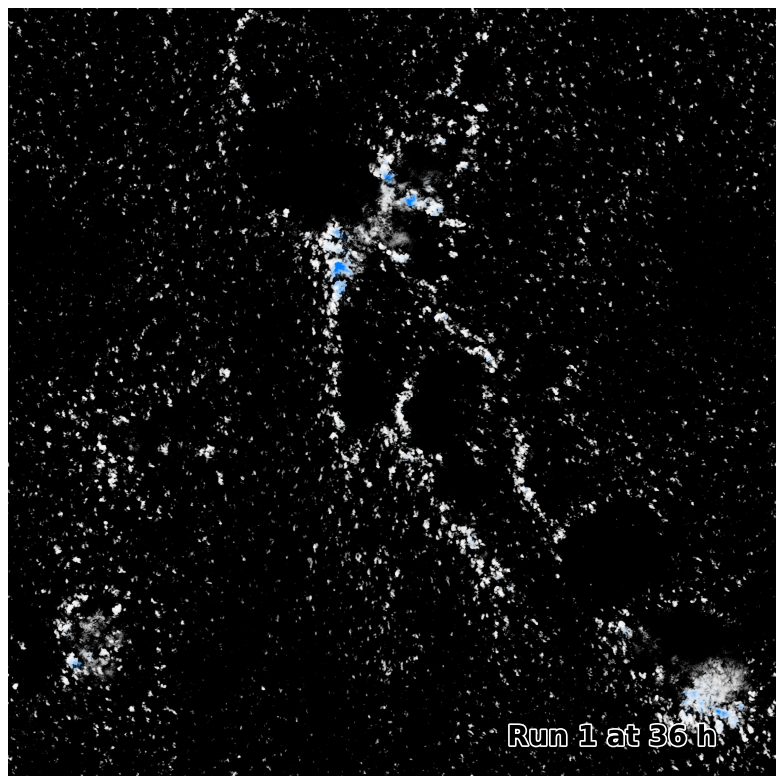

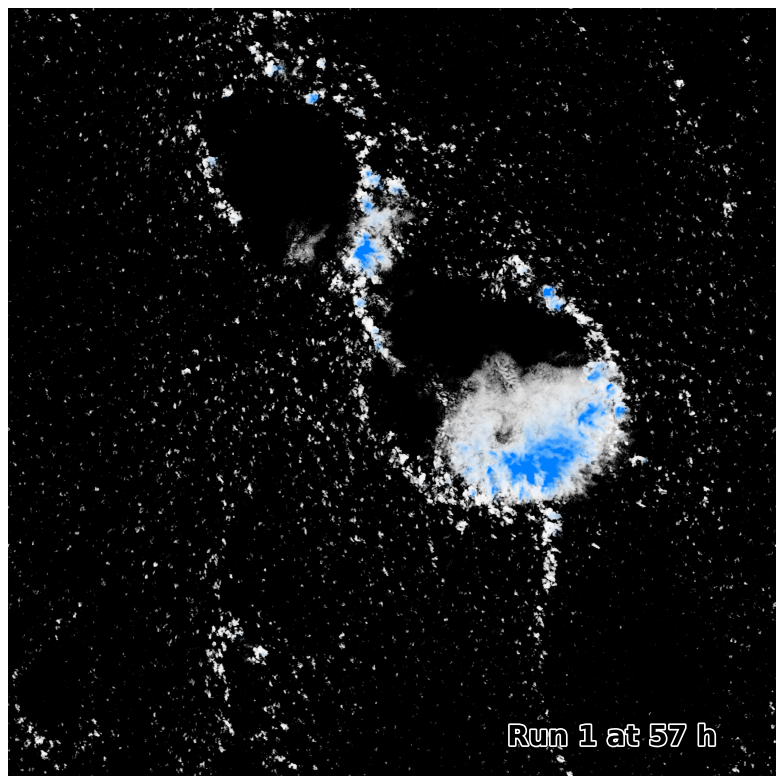

In [7]:
# Figure 4, snapshots
cloudplot( 6, member=1)
cloudplot(12, member=1)
cloudplot(24, member=1)
cloudplot(36, member=1, roll=(0,-600))
fig_lwp, fig_rwp = cloudplot(57, member=1, roll=(500,0)) 
# save handles for making colorbars below

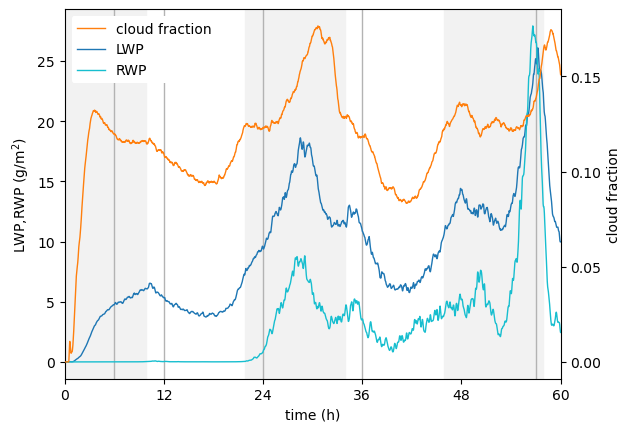

In [9]:
# Figure 4, time series
fig, ax1 = plt.subplots()

cfrac = np.maximum(ds_timeseries.sel(member=1).cfrac, 0)
lwp = ds_timeseries.sel(member=1).lwp_bar
rwp = ds_timeseries.sel(member=1).rwp_bar
time = (ds_timeseries.time - start_time) / np.timedelta64(1, 'h')

# time axis ticks on multiples of 12
ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(12))

plt.xlim((0,60))

ax2 = ax1.twinx()
ax2.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.05))
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

g1, = ax2.plot(time, cfrac  , lw=1, label='cloud fraction', color = 'C1')
g2, = ax1.plot(time, lwp*1000, lw=1, label='LWP', color='C0')
g3, = ax1.plot(time, rwp*1000, lw=1, label='RWP', color='C9')

ax2.set(ylabel='cloud fraction')
ax1.set(ylabel=r'LWP,RWP (g/m$^2$)')
ax1.set(xlabel='time (h)')

# shade the local night - 18..06 in local time 
offset = -58/360 * 24  # domain is at 58 deg W = UTC-4. 
for n in range(-1,3):
    fr = 18   - offset + n*24
    to = 24+6 - offset + n*24
    ax1.axvspan(fr, to, color='0.95', zorder=-20)

# mark times of snapshots with vertical bars
for t in (6, 12, 24, 36, 57):
    ax1.axvline(t, color='0.7', lw=1, zorder=-10)

legend = plt.legend([g1, g2, g3], [g1.get_label(), g2.get_label(), g3.get_label()])
frame = legend.get_frame()
frame.set_facecolor('1.0')
frame.set_alpha(1)
frame.set_linewidth(0)

plt.savefig('timegraphs_matplotliboutput.svg')




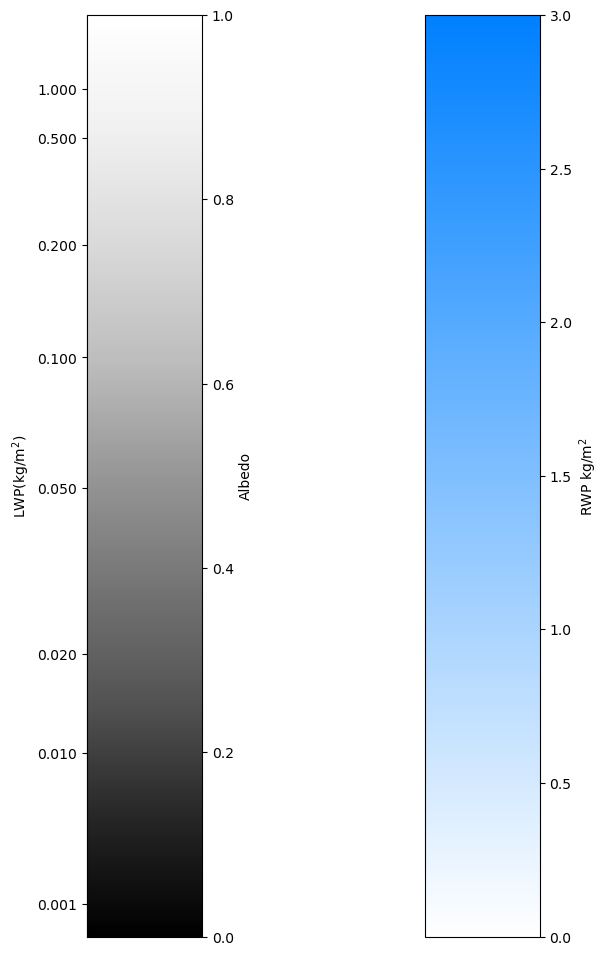

In [10]:
# Figure 4, color bars

fig, axes = plt.subplots(figsize=(size/dpi*.8, size/dpi), nrows=1, ncols=2, squeeze=True)

m=0.02
axes[0].set_position([.24, m, .15, 1-2*m]) # fill whole image
axes[1].set_position([.68, m, .15, 1-2*m]) # fill whole image
    
    
cb_rwp = plt.colorbar(fig_rwp, cax=axes[1], label=r'RWP kg/m$^2$')
cb_lwp_albedo = plt.colorbar(fig_lwp, cax=axes[0], label='Albedo')
    
cb_lwp = cb_lwp_albedo.ax.secondary_yaxis('left',functions=(albedo_inv, albedo))
cb_lwp.yaxis.set_major_locator(ticker.FixedLocator([0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]))
cb_lwp.set_ylabel(r'LWP(kg/m$^2$)')

plt.savefig('colorbars.png')
